## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import percentileofscore

## Read Data & Preprocess

In [2]:
df = pd.read_csv('./data/Day-ahead_Prices_60min.csv')

In [3]:
# Rename columns for simplicity, drop missing/invariant columns
df = df.rename(columns={'MTU (CET/CEST)': "dt", 'Day-ahead Price [EUR/MWh]': 'price'})
df = df.iloc[:, :2]  # other two columns were invariant or missing

#### Convert `MTU (CET/CEST)` to starting of 60 min contract

In [4]:
df['dt'] = df['dt'].apply(lambda x: ''.join(x.split(' - ')[0])) # take first time listed
df['dt'] = pd.to_datetime(df['dt'], format='%d.%m.%Y %H:%M')

#### Engineer Time Features: Date, Month, Day of Month (dom), Day of Week (dow), Hour of Day

In [5]:
df['date'] = df['dt'].dt.date
df['hour'] = df['dt'].dt.hour
df['month'] = df['dt'].dt.month
df['dow'] = df['dt'].dt.dayofweek  # numeric day, 0 is Monday, 6 is Sunday
df['dom'] = df['date'].astype(str).apply(lambda x: int(x.split('-')[-1]))  # date of month

In [6]:
df

,dt,price,date,hour,month,dow,dom
0,2022-01-01 00:00:00,50.05,2022-01-01,0,1,5,1
1,2022-01-01 01:00:00,41.33,2022-01-01,1,1,5,1
2,2022-01-01 02:00:00,43.22,2022-01-01,2,1,5,1
3,2022-01-01 03:00:00,45.46,2022-01-01,3,1,5,1
4,2022-01-01 04:00:00,37.67,2022-01-01,4,1,5,1
...,...,...,...,...,...,...,...
4339,2022-06-30 19:00:00,479.00,2022-06-30,19,6,3,30
4340,2022-06-30 20:00:00,450.00,2022-06-30,20,6,3,30
4341,2022-06-30 21:00:00,394.21,2022-06-30,21,6,3,30
4342,2022-06-30 22:00:00,355.17,2022-06-30,22,6,3,30


## Exploratory Data Analysis (EDA)

In [7]:
df.shape

(4344, 7)

In [8]:
print(df['dt'].min())
print(df['dt'].max())

2022-01-01 00:00:00
2022-06-30 23:00:00


In [9]:
df['price'].describe()

count    4343.000000
mean      185.802167
std        90.656821
min       -19.040000
25%       122.150000
50%       189.000000
75%       232.935000
max       700.000000
Name: price, dtype: float64

In [10]:
df[df['price']<0].shape

(38, 7)

In [11]:
df.isnull().mean()

dt       0.00000
price    0.00023
date     0.00000
hour     0.00000
month    0.00000
dow      0.00000
dom      0.00000
dtype: float64

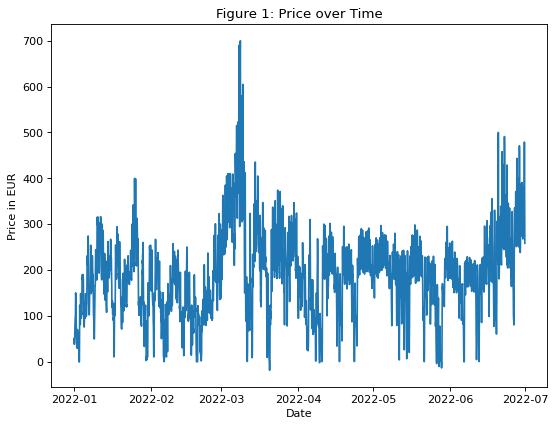

In [12]:
figure(figsize=(8, 6), dpi=80)
sns.lineplot(df, x='dt', y='price')
plt.ylabel('Price in EUR')
plt.xlabel('Date')
plt.title('Figure 1: Price over Time')
plt.show()

# Question 1.1

We start by calculating the percentile rank, a common distributional statistic, of each price grouped by date using the function `series_percentile`. An intutitive explanation of percentile rank is e.g. 80% means that 80% of the scores in a series/array are below the given score. 

Using percentile rank conditions out price shifts over time such as what we see in `Figure 1` above. This allows us to compare prices *relative* to the other prices for a given day, rather than compare them absolutely across time. Percentile rank is also more robust to outliers than mean-based scores (e.g. [standardized score](https://en.wikipedia.org/wiki/Standard_score))

In [13]:
def series_percentile(series: pd.Series) -> pd.Series:
    """
    Calculates the average percentage ranking of a pd.Series. In case of multiple matches, average 
        the percentage rankings of all matching scores.
    :param series: pd.Series, a single day's price data
    :return: pd.Series
    """
    return pd.Series([percentileofscore(series, a, 'rank') for a in series])

In [14]:
perc = df.groupby('date')['price'].apply(series_percentile).reset_index()
perc = perc.rename(columns={'price': 'percentile'})
df = pd.concat([df, perc['percentile']], axis=1)

In [15]:
df

,dt,price,date,hour,month,dow,dom,percentile
0,2022-01-01 00:00:00,50.05,2022-01-01,0,1,5,1,37.500000
1,2022-01-01 01:00:00,41.33,2022-01-01,1,1,5,1,16.666667
2,2022-01-01 02:00:00,43.22,2022-01-01,2,1,5,1,20.833333
3,2022-01-01 03:00:00,45.46,2022-01-01,3,1,5,1,29.166667
4,2022-01-01 04:00:00,37.67,2022-01-01,4,1,5,1,4.166667
...,...,...,...,...,...,...,...,...
4339,2022-06-30 19:00:00,479.00,2022-06-30,19,6,3,30,100.000000
4340,2022-06-30 20:00:00,450.00,2022-06-30,20,6,3,30,95.833333
4341,2022-06-30 21:00:00,394.21,2022-06-30,21,6,3,30,87.500000
4342,2022-06-30 22:00:00,355.17,2022-06-30,22,6,3,30,70.833333


Next, we calculate some measures of central tendency (i.e. the mean and median) by hour of day. This tells us typically what times of day energy prices are highest and lowest. 

In [16]:
hourly_mean = df.groupby('hour')['percentile'].mean()
hourly_median = df.groupby('hour')['percentile'].median()

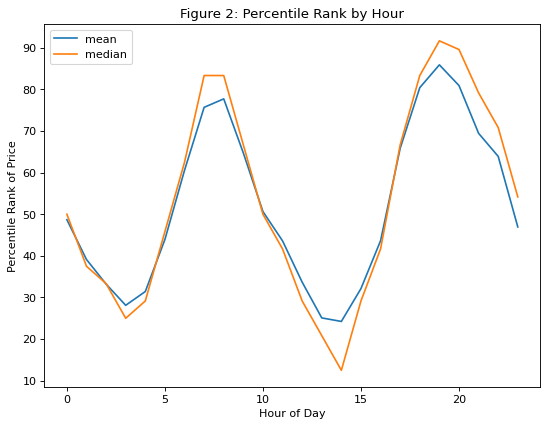

In [17]:
figure(figsize=(8, 6), dpi=80)
sns.lineplot(hourly_mean, label='mean')
sns.lineplot(hourly_median, label='median')
plt.ylabel('Percentile Rank of Price')
plt.xlabel('Hour of Day')
plt.title('Figure 2: Percentile Rank by Hour')
plt.show()

### Answer

According to `Figure 2`, **energy prices are typically *lowest* between 1h and 5h and again between 11h and 15h, meaning that profits could be maximized by *charging* during these off-peak times.**

Conversely, **energy prices are typically *highest* from 6h-10h and 16h-22h, meaning profits could be maximized by *discharging* during these peak times.**